### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/timing_runs/north_dakota/2023_07_14_09_44_35/count_data

deaths.csv                       risk_exposure_time.hdf
deaths.hdf                       sbp_medication_person_time.csv
healthcare_visits.csv            sbp_medication_person_time.hdf
healthcare_visits.hdf            state_person_time.csv
intervention_person_time.csv     state_person_time.hdf
intervention_person_time.hdf     transition_count.csv
ldlc_medication_person_time.csv  transition_count.hdf
ldlc_medication_person_time.hdf  ylds.csv
polypill_person_time.csv         ylds.hdf
polypill_person_time.hdf         ylls.csv
risk_exposure_time.csv           ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/timing_runs/north_dakota/2023_07_14_09_44_35/count_data/'

### Exploring Data

In [4]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,value
0,0,Female,2023,acute_ischemic_stroke,deaths,29,baseline,25_to_29,0
1,1,Female,2023,acute_ischemic_stroke,deaths,29,lifestyle_100,25_to_29,0
2,2,Female,2023,acute_ischemic_stroke,deaths,29,outreach_100,25_to_29,0
3,3,Female,2023,acute_ischemic_stroke,deaths,29,polypill_100,25_to_29,0
4,4,Female,2023,acute_ischemic_stroke,deaths,29,baseline,30_to_34,0


In [5]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

162695286.81177273

### Total DALYs by Year

In [6]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 

daly_total.head()

,sex,age,input_draw,year,yll,yld,daly
0,Female,25_to_29,29,2023,1477.452484,148.564491,1626.016975
1,Female,25_to_29,29,2024,1976.540677,185.486123,2162.026800
2,Female,25_to_29,29,2025,1994.718272,206.940698,2201.658970
3,Female,25_to_29,29,2026,2662.786941,228.112273,2890.899214
4,Female,25_to_29,29,2027,1698.665288,241.227608,1939.892895


In [7]:
daly_sum = (daly_total
                .groupby(['year'])
                .daly.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum.head()

,year,mean,2.5%,97.5%
0,2023,7102.064684,1740.608849,16786.378637
1,2024,7210.017177,1719.104194,16763.638355
2,2025,7295.987761,1999.103522,17015.774383
3,2026,7351.810349,2030.555672,16915.359548
4,2027,7387.303366,1780.858671,17434.458396


### All Cause Mortality Graphs

In [8]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,1.371875,0.0,8.100
1,25_to_29,Female,2024,1.487500,0.0,9.125
2,25_to_29,Female,2025,1.446875,0.0,7.125
3,25_to_29,Female,2026,1.253125,0.0,8.000
4,25_to_29,Female,2027,1.062500,0.0,7.050


#### All Cause Mortality Graph with Rate

In [9]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw']).ptvalue.sum().reset_index()

per_time_group.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,Female,2023,29,41753.232033
1,25_to_29,Female,2023,232,41656.640657
2,25_to_29,Female,2023,357,41895.819302
3,25_to_29,Female,2023,394,41456.098563
4,25_to_29,Female,2023,602,41218.759754


In [10]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.001056,0.000425,0.002274
1,25_to_29,Female,2024,0.001166,0.000238,0.002597
2,25_to_29,Female,2025,0.001154,0.000541,0.002461
3,25_to_29,Female,2026,0.001016,0.000324,0.002026
4,25_to_29,Female,2027,0.000878,0.000252,0.001965


### Cause Specific Mortality Graphs
#### Acute Stroke

In [11]:
deaths_cause = (deaths
               .groupby(['age', 'sex', 'year', 'cause'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = deaths_cause.loc[(deaths_cause['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

,index,age,sex,year,cause,mean,2.5%,97.5%
0,0,25_to_29,Female,2023,acute_ischemic_stroke,0.000,0.0,0.0
1,8,25_to_29,Female,2024,acute_ischemic_stroke,0.200,0.0,2.0
2,16,25_to_29,Female,2025,acute_ischemic_stroke,0.300,0.0,3.0
3,24,25_to_29,Female,2026,acute_ischemic_stroke,0.375,0.0,4.0
4,32,25_to_29,Female,2027,acute_ischemic_stroke,0.000,0.0,0.0


In [12]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause']).value.sum().reset_index()
acute_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

,index,age,sex,year,input_draw,cause,value
0,0,25_to_29,Female,2023,29,acute_ischemic_stroke,0
1,8,25_to_29,Female,2023,232,acute_ischemic_stroke,0
2,16,25_to_29,Female,2023,357,acute_ischemic_stroke,0
3,24,25_to_29,Female,2023,394,acute_ischemic_stroke,0
4,32,25_to_29,Female,2023,602,acute_ischemic_stroke,0


In [13]:
acute_rate_2 = pd.concat([acute_rate, per_time_group.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']

acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000000,0.0,0.000000
1,25_to_29,Female,2024,0.000020,0.0,0.000151
2,25_to_29,Female,2025,0.000030,0.0,0.000232
3,25_to_29,Female,2026,0.000038,0.0,0.000296
4,25_to_29,Female,2027,0.000000,0.0,0.000000


#### Chronic Stroke

In [14]:
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time_group.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate_summ = (chronic_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_summ

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000000,0.000000,0.000000
1,25_to_29,Female,2024,0.000000,0.000000,0.000000
2,25_to_29,Female,2025,0.000000,0.000000,0.000000
3,25_to_29,Female,2026,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
536,95_plus,Male,2037,0.006280,0.000000,0.013471
537,95_plus,Male,2038,0.007821,0.000512,0.016062
538,95_plus,Male,2039,0.005840,0.000000,0.012512
539,95_plus,Male,2040,0.005808,0.000000,0.012632


#### Acute Myocardial Infarction - includes both heart failure and no heart failure

In [15]:
acute_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure')].reset_index()
acute_MI_rate = acute_MI_rate.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
acute_MI_rate['mean_rate'] = acute_MI_rate['value'] / acute_MI_rate['ptvalue']
acute_MI_rate_summ = (acute_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000167,0.0,0.001346
1,25_to_29,Female,2024,0.000133,0.0,0.001104
2,25_to_29,Female,2025,0.000159,0.0,0.001206
3,25_to_29,Female,2026,0.000100,0.0,0.001021
4,25_to_29,Female,2027,0.000099,0.0,0.000839


#### Post Myocaridal Infarction

In [16]:
post_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_rate = pd.concat([post_MI_rate, per_time_group.ptvalue], axis=1)
post_MI_rate['mean_rate'] = post_MI_rate['value'] / post_MI_rate['ptvalue']
post_MI_rate_summ = (post_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000096,0.0,0.000269
1,25_to_29,Female,2024,0.000157,0.0,0.000665
2,25_to_29,Female,2025,0.000110,0.0,0.000436
3,25_to_29,Female,2026,0.000112,0.0,0.000363
4,25_to_29,Female,2027,0.000134,0.0,0.000413


#### Heart Failure

In [17]:
HF_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_rate = HF_rate.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
HF_rate['mean_rate'] = HF_rate['value'] / HF_rate['ptvalue']
HF_rate_summ = (HF_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000173,0.0,0.000633
1,25_to_29,Female,2024,0.000240,0.0,0.001138
2,25_to_29,Female,2025,0.000209,0.0,0.000652
3,25_to_29,Female,2026,0.000177,0.0,0.000660
4,25_to_29,Female,2027,0.000149,0.0,0.000681


### Excess Mortality rate

#### Post Myocardial Infarction

In [18]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_post_MI = per_time_state.loc[(per_time_state['state'] == 'post_myocardial_infarction')].reset_index()

post_MI_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_emr = pd.concat([post_MI_emr, per_time_post_MI.ptvalue], axis=1)
post_MI_emr['mean_rate'] = post_MI_emr['value'] / post_MI_emr['ptvalue']
post_MI_emr_summ = (post_MI_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.051423,0.0,0.172112
1,25_to_29,Female,2024,0.026804,0.0,0.102431
2,25_to_29,Female,2025,0.081387,0.0,0.414636
3,25_to_29,Female,2026,0.032779,0.0,0.112268
4,25_to_29,Female,2027,0.036418,0.0,0.158339


#### Heart Failure EMR

In [19]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'acute_myocardial_infarction_and_heart_failure',
       'chronic_ischemic_stroke',
       'heart_failure_from_ischemic_heart_disease',
       'heart_failure_residual', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [20]:
per_time_HF = per_time_state.loc[(per_time_state['state'] == 'heart_failure_from_ischemic_heart_disease') | (per_time_state['state'] == 'heart_failure_residual')].reset_index()
HF_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_emr = HF_emr.merge(per_time_HF[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
HF_emr['mean_rate'] = HF_emr['value'] / HF_emr['ptvalue']
HF_emr_summ = (HF_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,inf,0.0,inf
1,25_to_29,Female,2024,inf,0.0,NaN
2,25_to_29,Female,2025,inf,0.0,NaN
3,25_to_29,Female,2026,inf,0.0,inf
4,25_to_29,Female,2027,0.706103,0.0,6.620156


### Prevalence 

#### Chronic + Acute Stroke

In [21]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'acute_ischemic_stroke')].reset_index()
prev_acute = prev_acute.rename(columns = {'ptvalue':'value'})
prev_acute_rate = pd.concat([prev_acute, per_time_group.ptvalue], axis=1)
prev_acute_rate['rate']= prev_acute_rate['value'] / prev_acute_rate['ptvalue']
prev_acute_rate_sum = (prev_acute_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_acute_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000070,0.0,0.000499
1,25_to_29,Female,2024,0.000094,0.0,0.000679
2,25_to_29,Female,2025,0.000078,0.0,0.000561
3,25_to_29,Female,2026,0.000083,0.0,0.000610
4,25_to_29,Female,2027,0.000070,0.0,0.000510


In [22]:
prev_chronic = per_time_state.loc[(per_time_state['state'] == 'chronic_ischemic_stroke')].reset_index()
prev_chronic = prev_chronic.rename(columns = {'ptvalue':'value'})
prev_chronic_rate = pd.concat([prev_chronic, per_time_group.ptvalue], axis=1)
prev_chronic_rate['rate']= prev_chronic_rate['value'] / prev_chronic_rate['ptvalue']
prev_chronic_rate_sum = (prev_chronic_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

#### Myocardial Infarction

In [23]:
prev_acute_MI = per_time_state.loc[(per_time_state['state'] == 'acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'acute_myocardial_infarction'))].reset_index()
prev_acute_MI = prev_acute_MI.rename(columns = {'ptvalue':'value'})
prev_acute_MI = prev_acute_MI.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
prev_acute_MI = prev_acute_MI.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_acute_MI['rate']= prev_acute_MI['value'] / prev_acute_MI['ptvalue']
prev_acute_MI_summ = (prev_acute_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000117,0.000000,0.000436
1,25_to_29,Female,2024,0.000104,0.000000,0.000439
2,25_to_29,Female,2025,0.000115,0.000002,0.000463
3,25_to_29,Female,2026,0.000093,0.000000,0.000408
4,25_to_29,Female,2027,0.000089,0.000000,0.000361


In [24]:
prev_post_MI = per_time_state.loc[(per_time_state['state'] == 'post_myocardial_infarction')].reset_index()
prev_post_MI = prev_post_MI.rename(columns = {'ptvalue':'value'})
prev_post_MI = pd.concat([prev_post_MI, per_time_group.ptvalue], axis=1)
prev_post_MI['rate']= prev_post_MI['value'] / prev_post_MI['ptvalue']
prev_post_MI_summ = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.002864,0.000682,0.009841
1,25_to_29,Female,2024,0.003298,0.000451,0.012143
2,25_to_29,Female,2025,0.003901,0.000283,0.014967
3,25_to_29,Female,2026,0.004423,0.000315,0.017454
4,25_to_29,Female,2027,0.004517,0.000245,0.017770


In [25]:
tran = pd.read_csv(sim_results_dir + '/transition_count.csv')
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_post_hf = person_time.loc[(person_time['state'].isin(['post_myocardial_infarction']))].reset_index()
tran_rate_post_to_hf = tran.loc[(tran['transition'].isin(['post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_post_to_hf = tran_rate_post_to_hf.groupby(groupby_cols).sum() / per_time_sus_post_hf.groupby(groupby_cols).sum()
tran_rate_post_to_hf_summ = (tran_rate_post_to_hf.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_post_to_hf_summ#.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 Female 2023  0.000000  0.000000  0.000000
                2024  0.000000  0.000000  0.000000
                2025  0.000000  0.000000  0.000000
                2026  0.000000  0.000000  0.000000
...                        ...       ...       ...
95_plus  Male   2037  0.156487  0.062945  0.299335
                2038  0.146957  0.024706  0.219623
                2039  0.118280  0.008983  0.202601
                2040  0.197240  0.087304  0.433718

[540 rows x 3 columns]

In [26]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_ami_post = person_time.loc[(person_time['state'].isin(['acute_myocardial_infarction']))].reset_index()
tran_rate_ami_to_post = tran.loc[(tran['transition'].isin(['acute_myocardial_infarction_to_post_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_ami_to_post = tran_rate_ami_to_post.groupby(groupby_cols).sum() / tran_rate_ami_to_post.groupby(groupby_cols).sum()
tran_rate_ami_to_post_summ = (tran_rate_ami_to_post.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_ami_to_post_summ.head()

mean  2.5%  97.5%
age      sex    year                   
25_to_29 Female 2023   1.0   1.0    1.0
                2024   1.0   1.0    1.0
                2025   1.0   1.0    1.0
                2026   1.0   1.0    1.0
                2027   1.0   1.0    1.0

### Prevalence of Heart Failure

In [27]:
prev_HF = per_time_state.loc[(per_time_state['state'] == 'heart_failure_from_ischemic_heart_disease') | ((per_time_state['state'] == 'heart_failure_residual'))].reset_index()
prev_HF = prev_HF.rename(columns = {'ptvalue':'value'})
prev_HF = prev_HF.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF['rate']= prev_HF['value'] / prev_HF['ptvalue']
prev_HF_summ = (prev_HF
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.001304,0.000007,0.003552
1,25_to_29,Female,2024,0.001235,0.000000,0.003411
2,25_to_29,Female,2025,0.001165,0.000000,0.003346
3,25_to_29,Female,2026,0.001167,0.000015,0.003343
4,25_to_29,Female,2027,0.001239,0.000030,0.003023


### Incidence of First Time Acute Ischemic Stroke

In [28]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

,index,age,sex,year,transition,mean,2.5%,97.5%
0,10,25_to_29,Female,2023,susceptible_to_ischemic_stroke_to_acute_ischem...,4.975,0.0,43.000
1,21,25_to_29,Female,2024,susceptible_to_ischemic_stroke_to_acute_ischem...,5.550,0.0,47.000
2,32,25_to_29,Female,2025,susceptible_to_ischemic_stroke_to_acute_ischem...,4.075,0.0,34.000
3,43,25_to_29,Female,2026,susceptible_to_ischemic_stroke_to_acute_ischem...,4.325,0.0,36.025
4,54,25_to_29,Female,2027,susceptible_to_ischemic_stroke_to_acute_ischem...,3.400,0.0,27.000


In [29]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

,index,age,sex,year,state,input_draw,ptvalue
0,80,25_to_29,Female,2023,susceptible_to_ischemic_stroke,29,40972.145106
1,81,25_to_29,Female,2023,susceptible_to_ischemic_stroke,232,41549.930185
2,82,25_to_29,Female,2023,susceptible_to_ischemic_stroke,357,41778.376454
3,83,25_to_29,Female,2023,susceptible_to_ischemic_stroke,394,41293.886379
4,84,25_to_29,Female,2023,susceptible_to_ischemic_stroke,602,41142.099932


In [30]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000477,0.0,0.003217
1,25_to_29,Female,2024,0.000542,0.0,0.003584
2,25_to_29,Female,2025,0.000407,0.0,0.002682
3,25_to_29,Female,2026,0.000440,0.0,0.002928
4,25_to_29,Female,2027,0.000353,0.0,0.002267


### Incidence of Acute Myocardial Infraction 

In [31]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['heart_failure_from_ischemic_heart_disease']))].reset_index()
tran_rate_MI_HF = tran.loc[(tran['transition'].isin(['heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure']))].reset_index()

In [32]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure','post_myocardial_infarction','heart_failure_from_ischemic_heart_disease']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction','susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 Female 2023  0.001487  0.000000  0.005591
                2024  0.001435  0.000000  0.006122
                2025  0.001436  0.000022  0.005823
                2026  0.001204  0.000000  0.005292
                2027  0.001161  0.000000  0.004518

### Incidence of Heart Failure 

In [33]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure','post_myocardial_infarction','acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF = tran.loc[(tran['transition'].isin(['acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_HF = tran_rate_HF.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_summ = (tran_rate_HF.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 Female 2023  0.000569  0.000213  0.000925
                2024  0.000500  0.000066  0.000864
                2025  0.000566  0.000099  0.001108
                2026  0.000574  0.000327  0.000952
                2027  0.000641  0.000125  0.001042

### Artifacts

In [34]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/

alabama.hdf               logs/               ohio.hdf
alaska.hdf                louisiana.hdf       oklahoma.hdf
arizona.hdf               maine.hdf           oregon.hdf
arkansas.hdf              maryland.hdf        paf-calculations/
california.hdf            massachusetts.hdf   pennsylvania.hdf
colorado.hdf              michigan.hdf        rhode_island.hdf
connecticut.hdf           minnesota.hdf       south_carolina.hdf
delaware.hdf              mississippi.hdf     south_dakota.hdf
district_of_columbia.hdf  missouri.hdf        south_dakotatennessee.hdf
florida.hdf               montana.hdf         tennessee.hdf
georgia.hdf               nebraska.hdf        texas.hdf
hawaii.hdf                nevada.hdf          utah.hdf
idaho.hdf                 new_hampshire.hdf   vermont.hdf
illinois.hdf              new_jersey.hdf      virginia.hdf
indiana.hdf               new_mexico.hdf      washington.hdf
iowa.hdf                  new_york.hdf        west_virginia.hdf
kansas.hdf                

In [35]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/north_dakota.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [36]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

,location,sex,age_start,age_end,year_start,year_end,value
0,North Dakota,Female,25.0,30.0,2019,2020,23883.142421
1,North Dakota,Female,30.0,35.0,2019,2020,24250.231547
2,North Dakota,Female,35.0,40.0,2019,2020,22518.523468
3,North Dakota,Female,40.0,45.0,2019,2020,18872.355036
4,North Dakota,Female,45.0,50.0,2019,2020,17952.638933


In [37]:
art_mort = art.load('sequela.acute_ischemic_stroke.excess_mortality_rate').reset_index()
art_mort.head()

,sex,age_start,age_end,year_start,year_end,draw_0,draw_1,draw_2,draw_3,draw_4,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Female,25.0,30.0,2019,2020,0.22040,0.32675,0.26025,0.32222,0.16992,...,0.21502,0.22970,0.22257,0.22412,0.36725,0.21115,0.25088,0.20903,0.18385,0.15241
1,Female,30.0,35.0,2019,2020,0.20700,0.26120,0.23545,0.30830,0.15905,...,0.20310,0.23490,0.23733,0.17955,0.32960,0.17285,0.20383,0.20345,0.17850,0.17461
2,Female,35.0,40.0,2019,2020,0.19960,0.23000,0.23215,0.24650,0.22415,...,0.20590,0.25670,0.24618,0.17685,0.26680,0.20955,0.23568,0.29635,0.22010,0.32880
3,Female,40.0,45.0,2019,2020,0.17378,0.20493,0.23978,0.20960,0.24083,...,0.19418,0.26062,0.23573,0.17785,0.23520,0.20817,0.25062,0.30270,0.22523,0.33420
4,Female,45.0,50.0,2019,2020,0.12953,0.18598,0.25833,0.19760,0.20908,...,0.16793,0.24667,0.20598,0.18255,0.23480,0.16872,0.24867,0.22250,0.19388,0.19080


In [38]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['north_dakota']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        #data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_949']]
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        #data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

#### All Cause Mortality Rates

In [39]:
art_acmr = load_artifact_data('cause', 'all_causes', 'cause_specific_mortality_rate')
art_acmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_acmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000770,0.000643,0.000921,North_dakota,cause_specific_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.001023,0.000863,0.001215,North_dakota,cause_specific_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.001197,0.001013,0.001419,North_dakota,cause_specific_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.001645,0.001397,0.001940,North_dakota,cause_specific_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.002328,0.001975,0.002746,North_dakota,cause_specific_mortality_rate,45_to_49


In [40]:
result_summary_allyears = (results_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allyears.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.001068,0.000215,0.002719
1,25_to_29,Male,0.001610,0.000900,0.002551
2,30_to_34,Female,0.001052,0.000376,0.001728
3,30_to_34,Male,0.001721,0.001067,0.002657
4,35_to_39,Female,0.001172,0.000551,0.001985


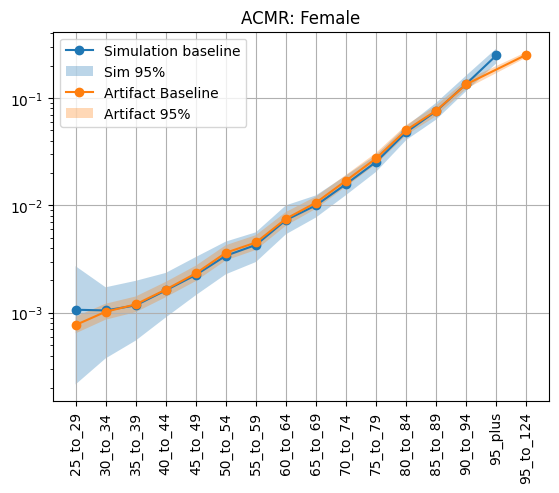

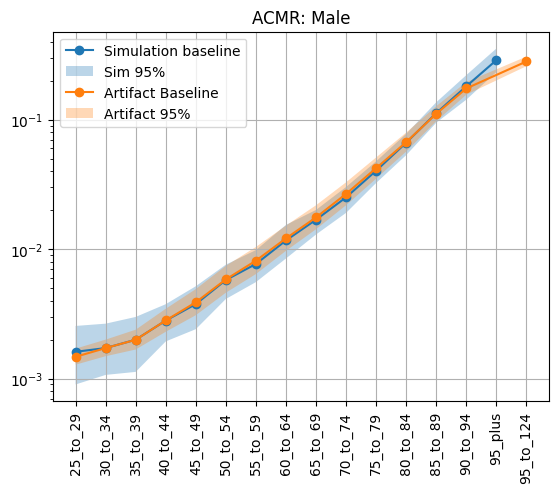

In [41]:
for sex in result_summary_allyears.sex.unique():
    plt.figure() 
    subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_acmr.loc[(art_acmr.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'ACMR: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Cause Specific Mortality Rates

#### Stroke

In [42]:
art_csmr = load_artifact_data('cause', 'ischemic_stroke', 'cause_specific_mortality_rate') 
art_csmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_csmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000001,7.717477e-07,0.000002,North_dakota,cause_specific_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000002,1.435340e-06,0.000004,North_dakota,cause_specific_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000003,1.868127e-06,0.000005,North_dakota,cause_specific_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000005,3.271984e-06,0.000007,North_dakota,cause_specific_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000008,5.252128e-06,0.000013,North_dakota,cause_specific_mortality_rate,45_to_49


In [43]:
acute_rate_sum_allyear = (acute_rate_2
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [44]:
chronic_rate_allyear = (chronic_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [45]:
acute_rate_2 = acute_rate_2.rename(columns = {'mean_rate':'acute_rate'})
chronic_rate = chronic_rate.rename(columns = {'mean_rate':'chronic_rate'})
total_stroke_rate = pd.concat([acute_rate_2, chronic_rate.chronic_rate], axis=1)
total_stroke_rate['total_rate'] = total_stroke_rate['acute_rate'] + total_stroke_rate['chronic_rate']

In [46]:
total_stroke_rate_allyear = (total_stroke_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_stroke_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000018,0.0,0.000208
1,25_to_29,Male,0.000007,0.0,0.000101
2,30_to_34,Female,0.000006,0.0,0.000100
3,30_to_34,Male,0.000003,0.0,0.000045
4,35_to_39,Female,0.000003,0.0,0.000000


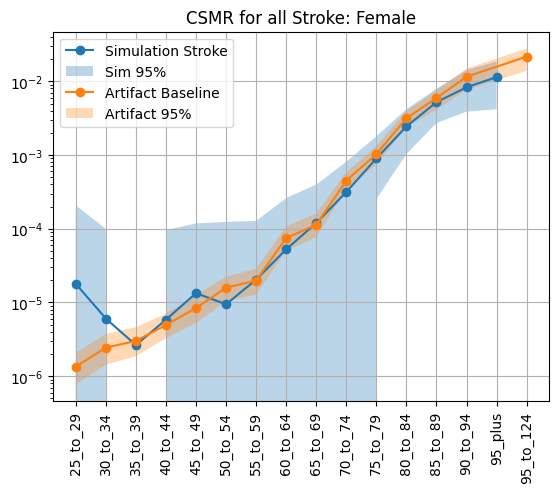

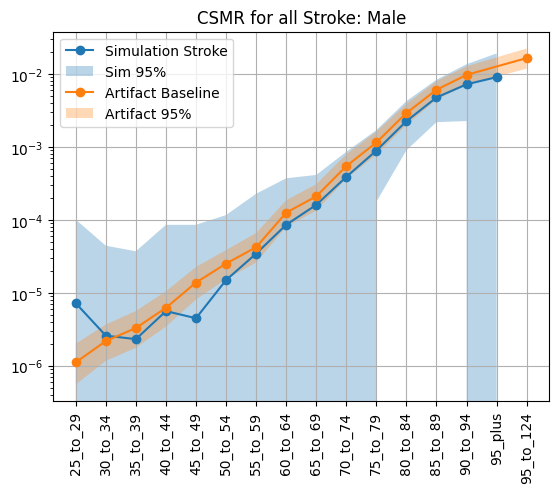

In [47]:
for sex in acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata4 = total_stroke_rate_allyear.loc[(total_stroke_rate_allyear.sex==sex)]
    plt.plot(subdata4['age'], subdata4['mean'], marker='o')
    plt.fill_between(subdata4['age'], subdata4['2.5%'], subdata4['97.5%'], alpha=.3)
    subdata3 = art_csmr.loc[(art_csmr.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'CSMR for all Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.yscale('log')
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation Stroke', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### IHD and HF Combined

In [48]:
art_csmr2 = load_artifact_data('cause', 'ischemic_heart_disease_and_heart_failure', 'cause_specific_mortality_rate') 
art_csmr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_csmr2.age_start,art_csmr2.age_end)]
art_csmr2.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000425,0.000314,0.000569,North_dakota,cause_specific_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000504,0.000364,0.000676,North_dakota,cause_specific_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000581,0.000416,0.000797,North_dakota,cause_specific_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000595,0.000449,0.000777,North_dakota,cause_specific_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000913,0.000733,0.001139,North_dakota,cause_specific_mortality_rate,45_to_49


In [49]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'acute_myocardial_infarction_and_heart_failure',
       'chronic_ischemic_stroke',
       'heart_failure_from_ischemic_heart_disease',
       'heart_failure_residual', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [50]:
IHD_HF_CSMR = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual') | (death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
IHD_HF_CSMR['mean_rate'] = IHD_HF_CSMR['value'] / IHD_HF_CSMR['ptvalue']
IHD_HF_CSMR_allyear = (IHD_HF_CSMR
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
IHD_HF_CSMR_allyear

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000779,0.000096,0.002422
1,25_to_29,Male,0.000703,0.000187,0.001643
2,30_to_34,Female,0.000636,0.000096,0.001346
3,30_to_34,Male,0.000756,0.000226,0.001462
...,...,...,...,...,...
26,90_to_94,Female,0.093668,0.070438,0.129976
27,90_to_94,Male,0.139164,0.108367,0.186978
28,95_plus,Female,0.127264,0.091985,0.186291
29,95_plus,Male,0.189405,0.137673,0.263389


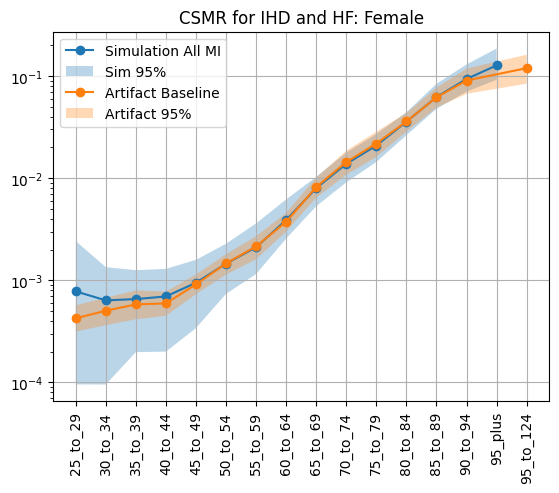

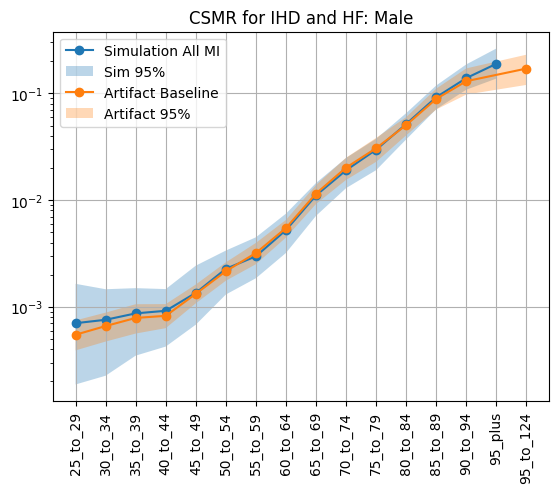

In [51]:
for sex in IHD_HF_CSMR_allyear.sex.unique():
    plt.figure() 
    subdata = IHD_HF_CSMR_allyear.loc[(IHD_HF_CSMR_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'CSMR for IHD and HF: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for Stroke

In [52]:
art_inc = load_artifact_data('cause', 'ischemic_stroke', 'incidence_rate')
art_inc['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc.age_start,art_inc.age_end)]
art_inc.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000104,0.000043,0.000211,North_dakota,incidence_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000144,0.000076,0.000250,North_dakota,incidence_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000201,0.000101,0.000346,North_dakota,incidence_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000310,0.000195,0.000469,North_dakota,incidence_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000472,0.000262,0.000766,North_dakota,incidence_rate,45_to_49


In [53]:
tran_rate_sum_allyear = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, 0.5, .975])
                 .filter(['50%', '2.5%', '97.5%'])
                 .reset_index())
tran_rate_sum_allyear.head()

,age,sex,year,50%,2.5%,97.5%
0,25_to_29,Female,2023,0.000096,0.0,0.003217
1,25_to_29,Female,2024,0.000049,0.0,0.003584
2,25_to_29,Female,2025,0.000050,0.0,0.002682
3,25_to_29,Female,2026,0.000000,0.0,0.002928
4,25_to_29,Female,2027,0.000051,0.0,0.002267


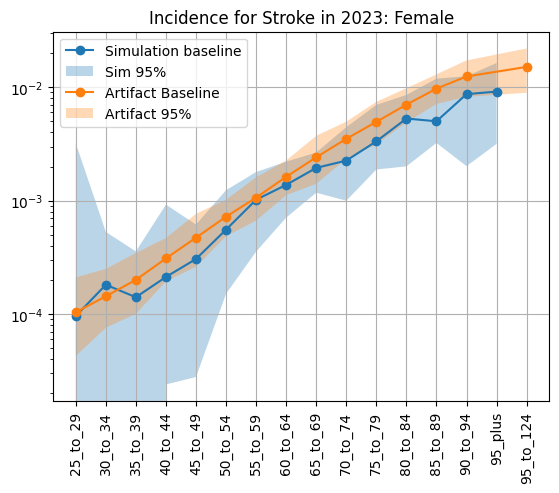

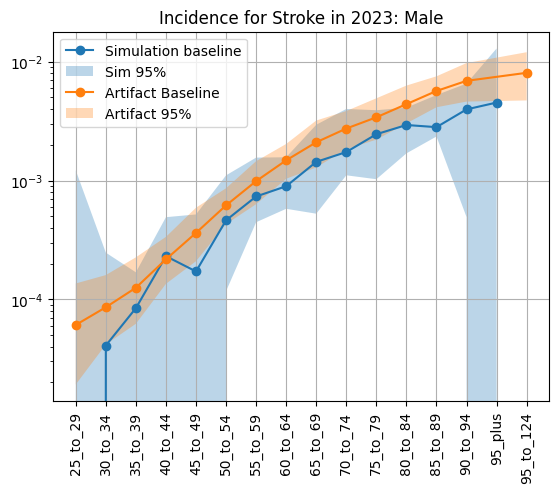

In [54]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex) & (tran_rate_sum_allyear.year==2023)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_inc.loc[(art_inc.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Incidence for Stroke in 2023: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

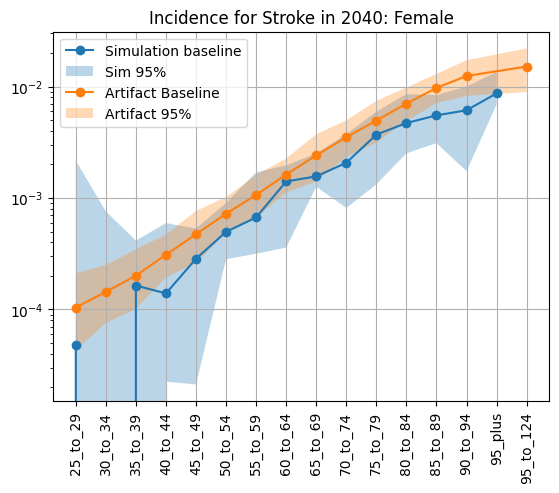

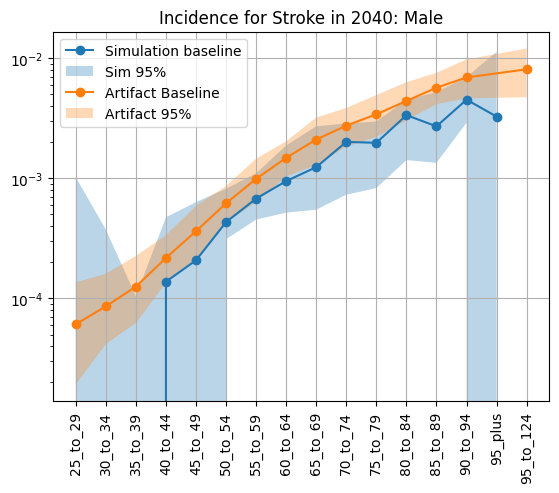

In [55]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex) & (tran_rate_sum_allyear.year==2040)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_inc.loc[(art_inc.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Incidence for Stroke in 2040: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for MI

In [56]:
art_inc_acute_MI = load_artifact_data('cause', 'acute_myocardial_infarction', 'incidence_rate')
art_inc_acute_MI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_acute_MI.age_start,art_inc_acute_MI.age_end)]
art_inc_acute_MI.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000440,0.000281,0.000618,North_dakota,incidence_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000495,0.000335,0.000672,North_dakota,incidence_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000412,0.000271,0.000594,North_dakota,incidence_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000532,0.000376,0.000734,North_dakota,incidence_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000857,0.000581,0.001163,North_dakota,incidence_rate,45_to_49


In [57]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_HF = tran_rate_MI_HF.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_rate_MI_HF = (tran_rate_MI_HF.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.5, 0.975])
                   .filter(['mean','50%', '2.5%', '97.5%']))
                 
tran_rate_MI_HF.head()

mean  50%  2.5%  97.5%
age      sex                           
25_to_29 Female   0.0  0.0   0.0    0.0
         Male     0.0  0.0   0.0    0.0
30_to_34 Female   0.0  0.0   0.0    0.0
         Male     0.0  0.0   0.0    0.0
35_to_39 Female   0.0  0.0   0.0    0.0

In [58]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_MI_summ_allyear = (tran_rate_MI_all.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.5, 0.975])
                   .filter(['mean','50%', '2.5%', '97.5%']))
                 
tran_MI_summ_allyear.head()

mean       50%      2.5%     97.5%
age      sex                                           
25_to_29 Female  0.001283  0.000410  0.000008  0.005221
         Male    0.000550  0.000371  0.000012  0.001866
30_to_34 Female  0.000793  0.000613  0.000091  0.002295
         Male    0.000795  0.000676  0.000113  0.001697
35_to_39 Female  0.000537  0.000463  0.000387  0.000906

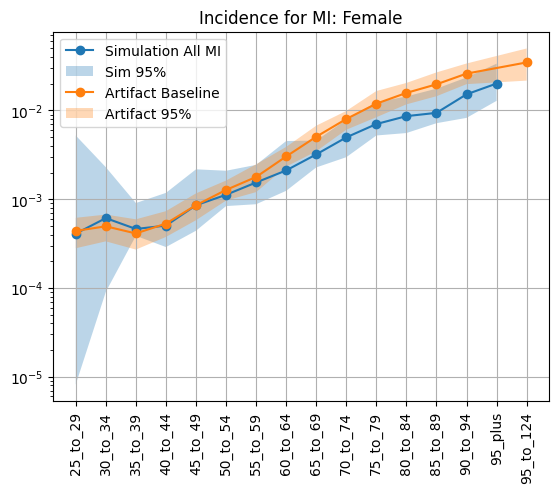

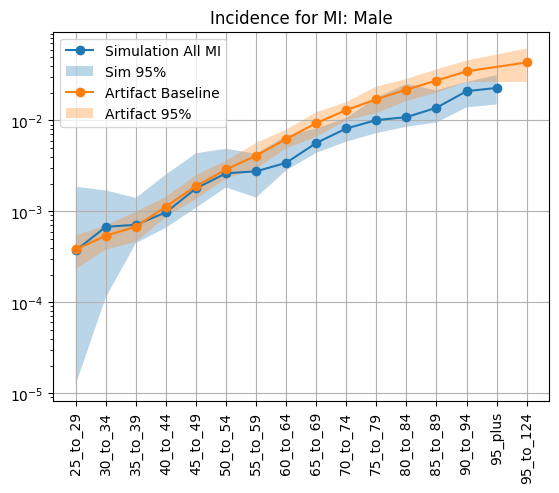

In [59]:
for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['50%'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_acute_MI.loc[(art_inc_acute_MI.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Incidence Rates for Heart Failure IHD

In [60]:
art_inc_HF_IHD = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'incidence_rate')
art_inc_HF_IHD['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_IHD.age_start,art_inc_HF_IHD.age_end)]
art_inc_HF_IHD.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000048,0.000033,0.000067,North_dakota,incidence_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000068,0.000050,0.000091,North_dakota,incidence_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000065,0.000040,0.000097,North_dakota,incidence_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000107,0.000076,0.000144,North_dakota,incidence_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000285,0.000220,0.000352,North_dakota,incidence_rate,45_to_49


In [61]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure','post_myocardial_infarction','acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF_IHD = tran.loc[(tran['transition'].isin(['acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF_IHD = tran_rate_HF_IHD.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_IHD_allyear = (tran_rate_HF_IHD.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_IHD_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 Female  0.000056  0.000018  0.000090
         Male    0.000109  0.000062  0.000139
30_to_34 Female  0.000077  0.000037  0.000128
         Male    0.000146  0.000107  0.000175
35_to_39 Female  0.000057  0.000049  0.000073

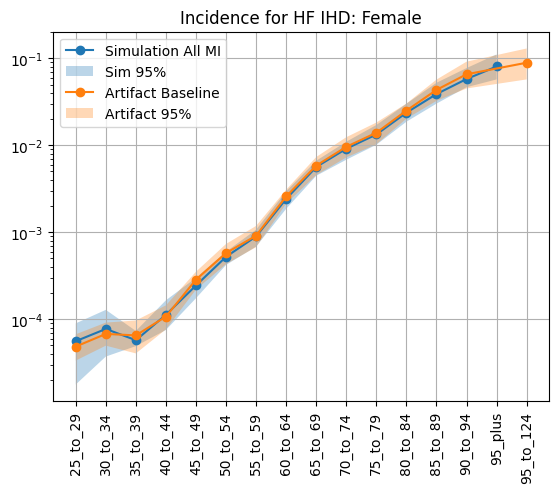

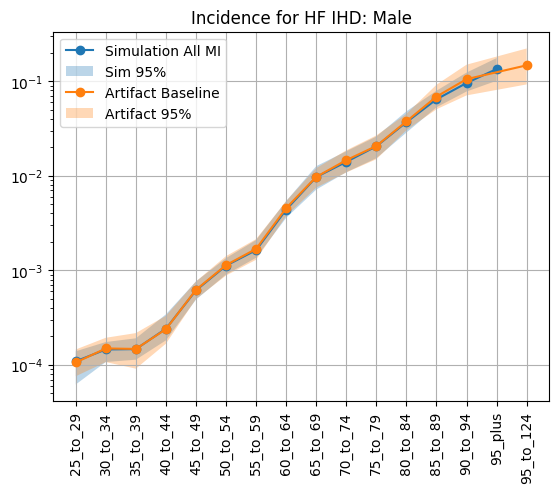

In [62]:
for sex in tran_rate_HF_IHD_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_IHD_allyear.loc[(tran_rate_HF_IHD_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_HF_IHD.loc[(art_inc_HF_IHD.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF IHD: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Incidence Rates for Heart Failure Residual

In [63]:
art_inc_HF_resid = load_artifact_data('cause', 'heart_failure_residual', 'incidence_rate')
art_inc_HF_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_resid.age_start,art_inc_HF_resid.age_end)]
art_inc_HF_resid.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000476,0.000329,0.000659,North_dakota,incidence_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000443,0.000325,0.000597,North_dakota,incidence_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000304,0.000189,0.000451,North_dakota,incidence_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000452,0.000321,0.000607,North_dakota,incidence_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000798,0.000614,0.000984,North_dakota,incidence_rate,45_to_49


In [64]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure']))].reset_index()
tran_rate_HF_resid = tran.loc[(tran['transition'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF_resid = tran_rate_HF_resid.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_resid_allyear = (tran_rate_HF_resid.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_resid_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 Female  0.000539  0.000313  0.000710
         Male    0.000648  0.000450  0.000752
30_to_34 Female  0.000483  0.000285  0.000628
         Male    0.000592  0.000368  0.000759
35_to_39 Female  0.000350  0.000251  0.000461

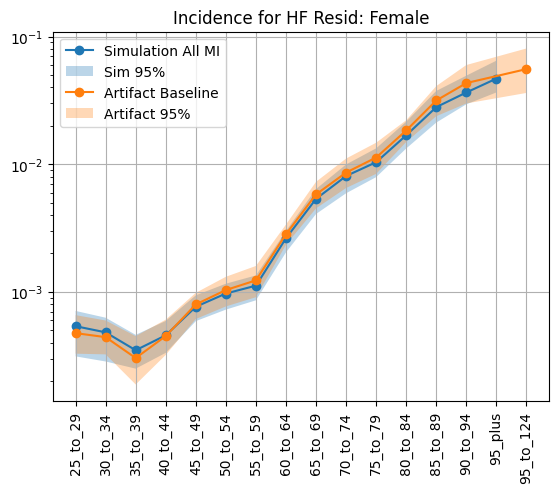

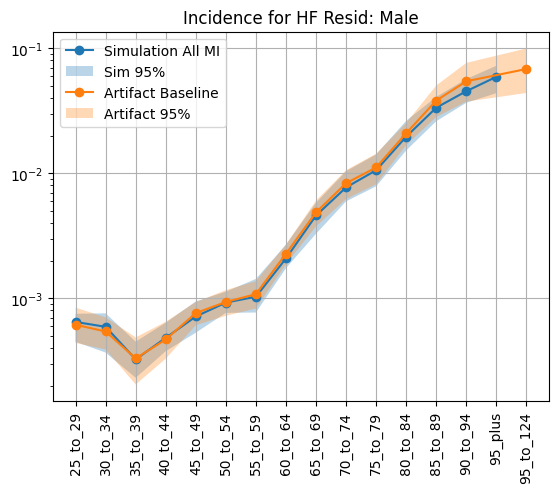

In [65]:
for sex in tran_rate_HF_resid_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_resid_allyear.loc[(tran_rate_HF_resid_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_HF_resid.loc[(art_inc_HF_resid.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF Resid: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Matches the artifact but the artifact looks weird for the youngest folks 

#### Prevalence Rates

In [66]:
prev_chronic_rate_sum_allyear = (prev_chronic_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [67]:
art_prev = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'prevalence')
art_prev['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev.age_start,art_prev.age_end)]
art_prev.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.002744,0.002022,0.003473,North_dakota,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.003420,0.002624,0.004398,North_dakota,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.004371,0.003377,0.005593,North_dakota,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.005736,0.004451,0.007375,North_dakota,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.007937,0.006112,0.010149,North_dakota,prevalence,45_to_49


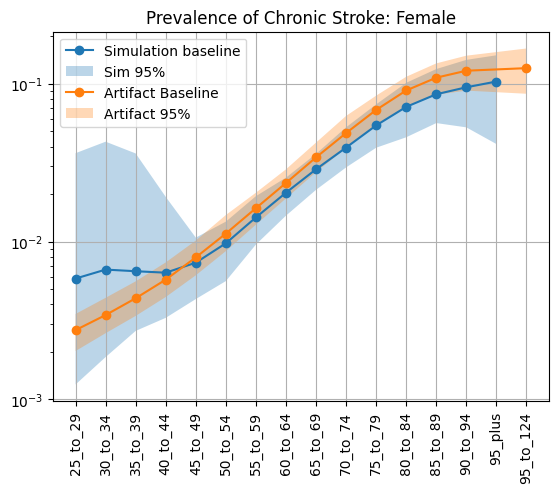

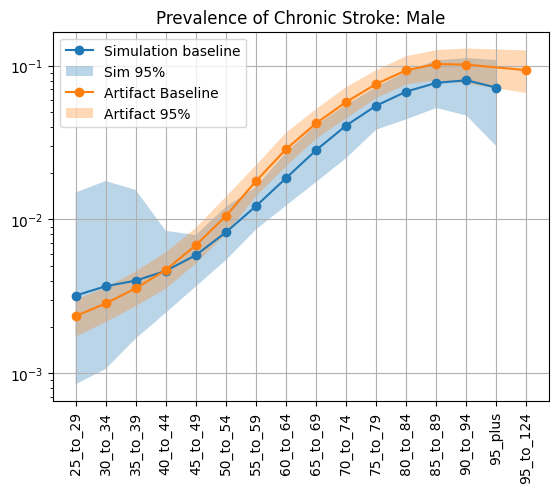

In [68]:
for sex in prev_chronic_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_chronic_rate_sum_allyear.loc[(prev_chronic_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev.loc[(art_prev.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [69]:
prev_acute_rate_sum_allyear = (prev_acute_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [70]:
art_prev2 = load_artifact_data('sequela', 'acute_ischemic_stroke', 'prevalence')
art_prev2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev2.age_start,art_prev2.age_end)]

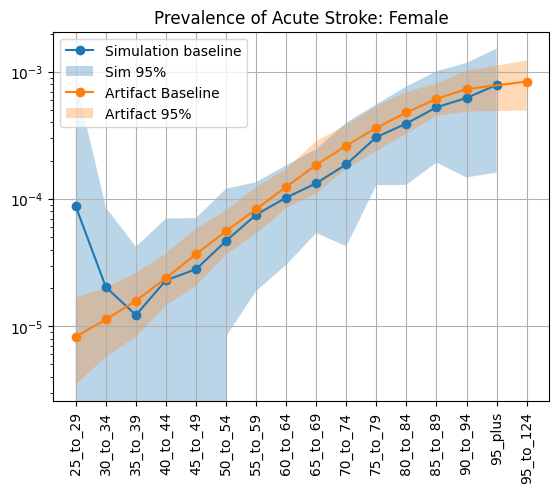

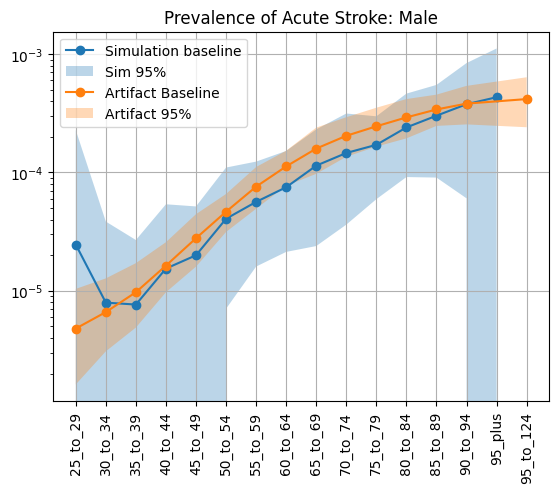

In [71]:
for sex in prev_acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_rate_sum_allyear.loc[(prev_acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev2.loc[(art_prev2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence of Post MI

In [72]:
art_prev3 = load_artifact_data('cause', 'post_myocardial_infarction', 'prevalence')
art_prev3['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev3.age_start,art_prev3.age_end)]
art_prev3.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.001076,0.000790,0.001379,North_dakota,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.002246,0.001651,0.002878,North_dakota,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.003610,0.002831,0.004478,North_dakota,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.005170,0.004160,0.006416,North_dakota,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.007191,0.005823,0.008765,North_dakota,prevalence,45_to_49


In [73]:
prev_post_MI_sum_allyear = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_sum_allyear.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.002864,0.000682,0.009841
1,25_to_29,Female,2024,0.003298,0.000451,0.012143
2,25_to_29,Female,2025,0.003901,0.000283,0.014967
3,25_to_29,Female,2026,0.004423,0.000315,0.017454
4,25_to_29,Female,2027,0.004517,0.000245,0.017770


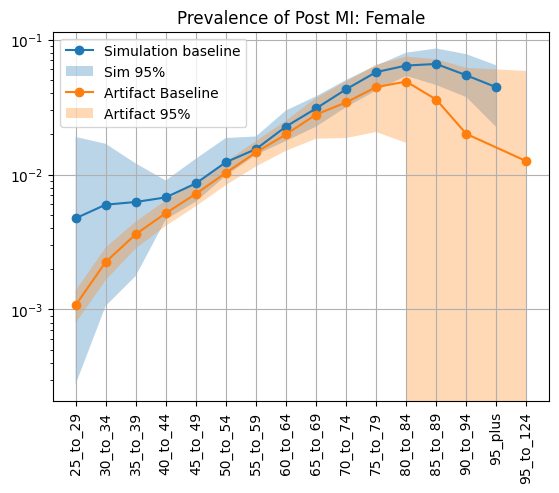

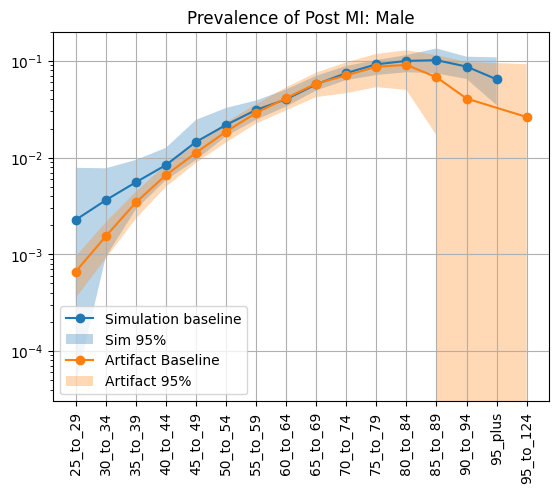

In [74]:
##Can try plotting the median 

for sex in prev_post_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_post_MI_sum_allyear.loc[(prev_post_MI_sum_allyear.sex==sex) & (prev_post_MI_sum_allyear.year == 2029)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev3.loc[(art_prev3.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [75]:
## 2023 looks pretty good but 2040 looks pretty bad 

#### Prevalence of Acute MI

In [76]:
art_prev4 = load_artifact_data('cause', 'acute_myocardial_infarction', 'prevalence')
art_prev4['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev4.age_start,art_prev4.age_end)]
art_prev4.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000029,0.000018,0.000041,North_dakota,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.000036,0.000024,0.000050,North_dakota,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.000031,0.000021,0.000044,North_dakota,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.000037,0.000025,0.000052,North_dakota,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.000060,0.000041,0.000080,North_dakota,prevalence,45_to_49


In [77]:
prev_acute_MI_sum_allyear = (prev_acute_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000098,0.000000,0.000466
1,25_to_29,Male,0.000042,0.000000,0.000182
2,30_to_34,Female,0.000060,0.000000,0.000223
3,30_to_34,Male,0.000061,0.000000,0.000175
4,35_to_39,Female,0.000041,0.000007,0.000093


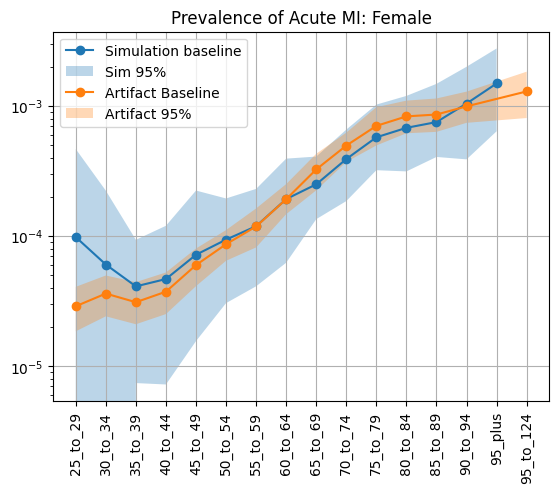

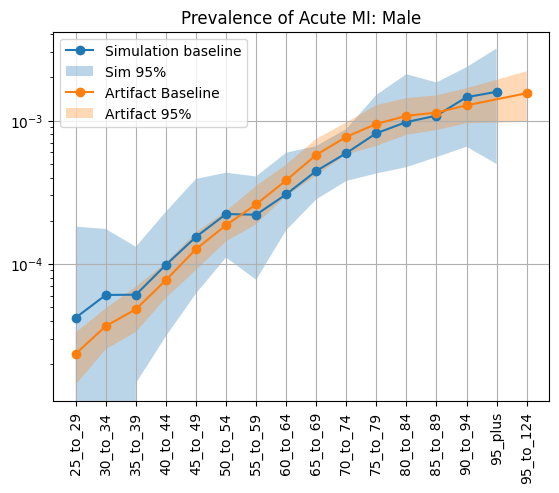

In [78]:
for sex in prev_acute_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_MI_sum_allyear.loc[(prev_acute_MI_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev4.loc[(art_prev4.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Prevalence of Heart Failure IHD

In [79]:
art_prev_hf_ihd = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'prevalence')
art_prev_hf_ihd['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_ihd.age_start,art_prev_hf_ihd.age_end)]
art_prev_hf_ihd.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000200,0.000145,0.000269,North_dakota,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.000418,0.000305,0.000564,North_dakota,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.000540,0.000400,0.000716,North_dakota,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.000519,0.000373,0.000704,North_dakota,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.001004,0.000803,0.001249,North_dakota,prevalence,45_to_49


In [80]:
prev_HF_IHD = per_time_state.loc[(per_time_state['state'] == 'heart_failure_from_ischemic_heart_disease')].reset_index()
prev_HF_IHD = prev_HF_IHD.rename(columns = {'ptvalue':'value'})
prev_HF_IHD = prev_HF_IHD.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_IHD['rate']= prev_HF_IHD['value'] / prev_HF_IHD['ptvalue']
prev_HF_IHD_allyear = (prev_HF_IHD
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_IHD_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000167,0.000000,0.000441
1,25_to_29,Male,0.000327,0.000007,0.000734
2,30_to_34,Female,0.000342,0.000018,0.000772
3,30_to_34,Male,0.000631,0.000216,0.001180
4,35_to_39,Female,0.000377,0.000081,0.000803


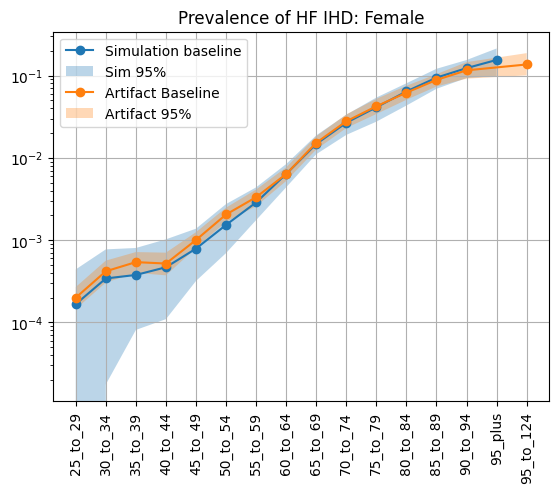

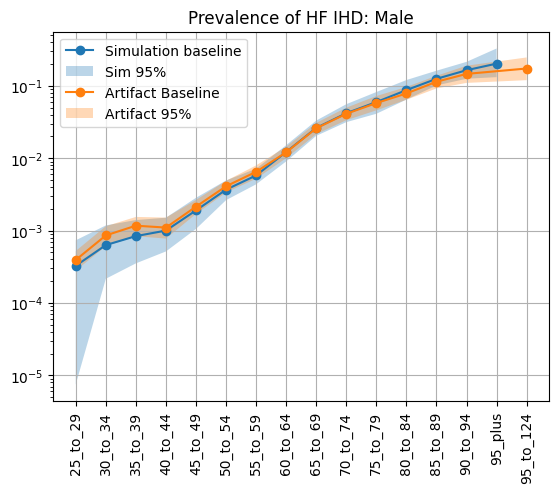

In [81]:
for sex in prev_HF_IHD_allyear.sex.unique():
    plt.figure() 
    subdata = prev_HF_IHD_allyear.loc[(prev_HF_IHD_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_hf_ihd.loc[(art_prev_hf_ihd.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of HF IHD: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Prevalence of Heart Failure Residual

In [82]:
art_prev_hf_resid = load_artifact_data('cause', 'heart_failure_residual', 'prevalence')
art_prev_hf_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_resid.age_start,art_prev_hf_resid.age_end)]
art_prev_hf_resid.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.001960,0.001425,0.002641,North_dakota,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.002726,0.001988,0.003674,North_dakota,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.002511,0.001860,0.003326,North_dakota,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.002173,0.001562,0.002945,North_dakota,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.002788,0.002230,0.003469,North_dakota,prevalence,45_to_49


In [83]:
prev_HF_resid = per_time_state.loc[(per_time_state['state'] == 'heart_failure_residual')].reset_index()
prev_HF_resid = prev_HF_resid.rename(columns = {'ptvalue':'value'})
prev_HF_resid = prev_HF_resid.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_resid['rate']= prev_HF_resid['value'] / prev_HF_resid['ptvalue']
prev_HF_resid_allyear = (prev_HF_resid
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_resid_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.002347,0.001127,0.003492
1,25_to_29,Male,0.002527,0.001433,0.003824
2,30_to_34,Female,0.002957,0.001456,0.004317
3,30_to_34,Male,0.003340,0.001667,0.004899
4,35_to_39,Female,0.002924,0.001607,0.004071


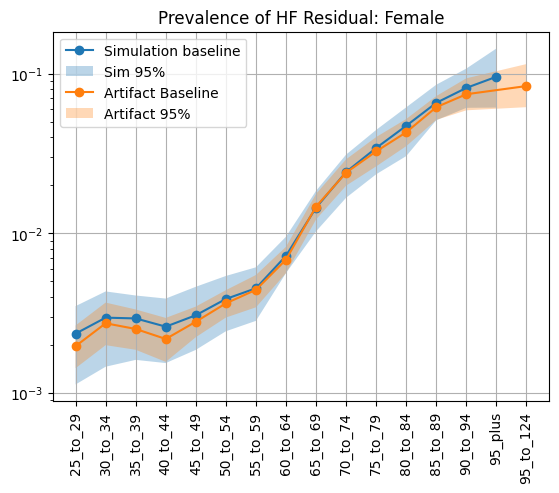

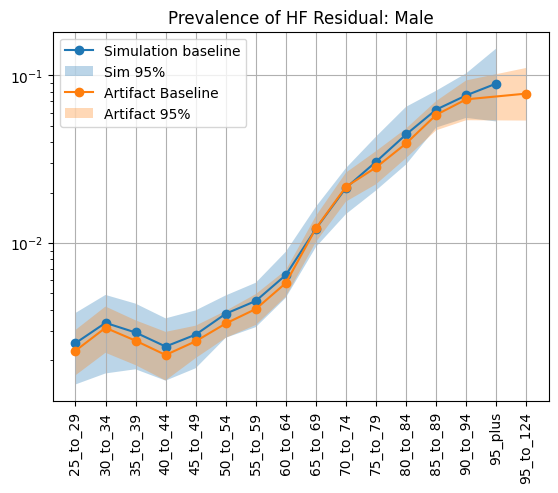

In [84]:
for sex in prev_HF_resid_allyear.sex.unique():
    plt.figure() 
    subdata = prev_HF_resid_allyear.loc[(prev_HF_resid_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_hf_resid.loc[(art_prev_hf_resid.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of HF Residual: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Excess Mortality Rate

#### Acute Stroke

In [85]:
art_emr = load_artifact_data('sequela', 'acute_ischemic_stroke', 'excess_mortality_rate')
art_emr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr.age_start,art_emr.age_end)]
art_emr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.240986,0.167642,0.336333,North_dakota,excess_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.220614,0.152445,0.314432,North_dakota,excess_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.240563,0.169248,0.323949,North_dakota,excess_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.238864,0.174597,0.323237,North_dakota,excess_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.215517,0.150744,0.297619,North_dakota,excess_mortality_rate,45_to_49


In [86]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'acute_ischemic_stroke')].reset_index()
acute_rate_emr = pd.concat([acute_rate, prev_acute.ptvalue], axis=1)
acute_rate_emr['mean_rate'] = acute_rate_emr['value'] / acute_rate_emr['ptvalue']

acute_rate_sum_allyear = (acute_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.315695,0.0,3.994922
1,25_to_29,Male,0.504337,0.0,7.247024
2,30_to_34,Female,0.148464,0.0,1.877324
3,30_to_34,Male,0.250065,0.0,4.156498
4,35_to_39,Female,0.193565,0.0,2.059680


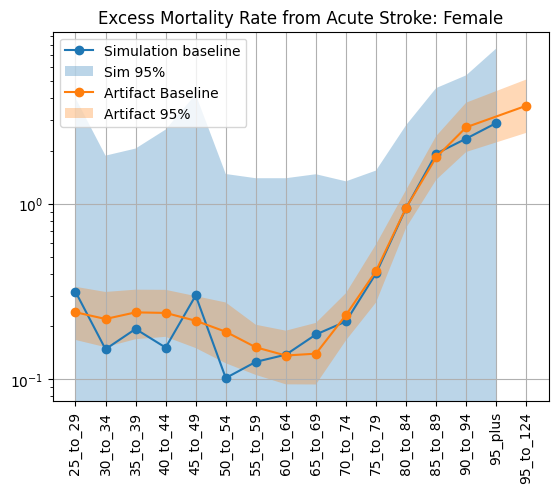

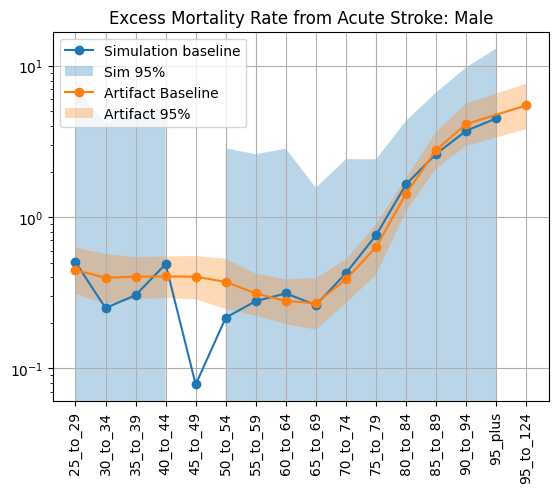

In [87]:
for sex in acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr.loc[(art_emr.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Chronic Stroke

In [88]:
art_emr2 = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'excess_mortality_rate')
art_emr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr2.age_start,art_emr2.age_end)]

In [89]:
chronic = per_time_state.loc[(per_time_state['state'] == 'chronic_ischemic_stroke')].reset_index()
#chronic = chronic.rename(columns = {'value':'ptvalue'})
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate_emr = pd.concat([chronic_rate, chronic.ptvalue], axis=1)
chronic_rate_emr['mean_rate'] = chronic_rate_emr['value'] / chronic_rate_emr['ptvalue']
chronic_rate_emr_allyear = (chronic_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


chronic_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000015,0.0,0.0
1,25_to_29,Male,0.000166,0.0,0.0
2,30_to_34,Female,0.000113,0.0,0.0
3,30_to_34,Male,0.000000,0.0,0.0
4,35_to_39,Female,0.000000,0.0,0.0


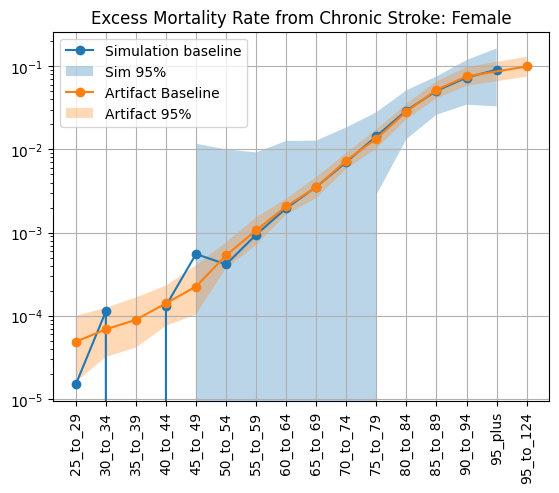

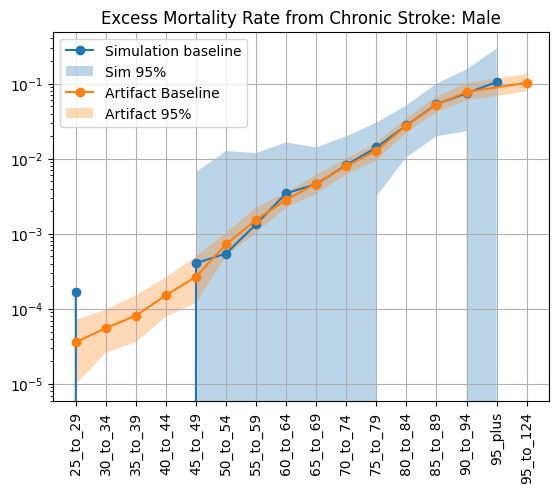

In [90]:
for sex in chronic_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = chronic_rate_emr_allyear.loc[(chronic_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr2.loc[(art_emr2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Acute MI

In [91]:
art_emr_acuteMI = load_artifact_data('cause', 'acute_myocardial_infarction', 'excess_mortality_rate')
art_emr_acuteMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_acuteMI.age_start,art_emr_acuteMI.age_end)]

In [92]:
acute_MI_EMR = per_time_state.loc[(per_time_state['state'] == 'acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'acute_myocardial_infarction'))].reset_index()
acute_MI_EMR = acute_MI_EMR.groupby(['age','year','sex','input_draw']).ptvalue.sum().reset_index()
acute_MI_emr_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.groupby(['age','year','sex','input_draw']).value.sum().reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.merge(acute_MI_EMR[['age','year','sex','input_draw','ptvalue']], on=['age','year','sex','input_draw'])
acute_MI_emr_rate['mean_rate'] = acute_MI_emr_rate['value'] / acute_MI_emr_rate['ptvalue']
acute_MI_emr_rate_allyear = (acute_MI_emr_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
acute_MI_emr_rate_allyear.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,1.804594,0.0,3.748101
1,25_to_29,Female,2024,2.408072,0.0,5.951618
2,25_to_29,Female,2025,2.806721,0.0,8.261607
3,25_to_29,Female,2026,0.652309,0.0,2.966448
4,25_to_29,Female,2027,1.954931,0.0,4.522143


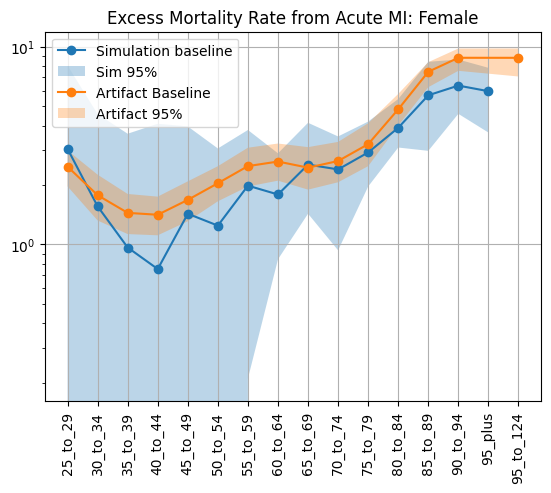

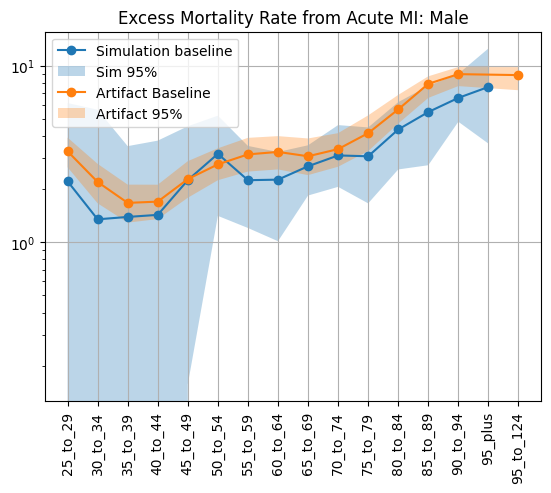

In [93]:
for sex in acute_MI_emr_rate_allyear.sex.unique():
    plt.figure() 
    subdata = acute_MI_emr_rate_allyear.loc[(acute_MI_emr_rate_allyear.sex==sex) & (acute_MI_emr_rate_allyear.year==2029)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_acuteMI.loc[(art_emr_acuteMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Post MI EMR

In [94]:
post_mi_rate_emr_allyear = (post_MI_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


post_mi_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.058987,0.0,0.306356
1,25_to_29,Male,0.035570,0.0,0.173769
2,30_to_34,Female,0.021385,0.0,0.096384
3,30_to_34,Male,0.020755,0.0,0.087531
4,35_to_39,Female,0.011984,0.0,0.048194


In [95]:
art_emr_postMI = load_artifact_data('cause', 'post_myocardial_infarction', 'excess_mortality_rate')
art_emr_postMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_postMI.age_start,art_emr_postMI.age_end)]

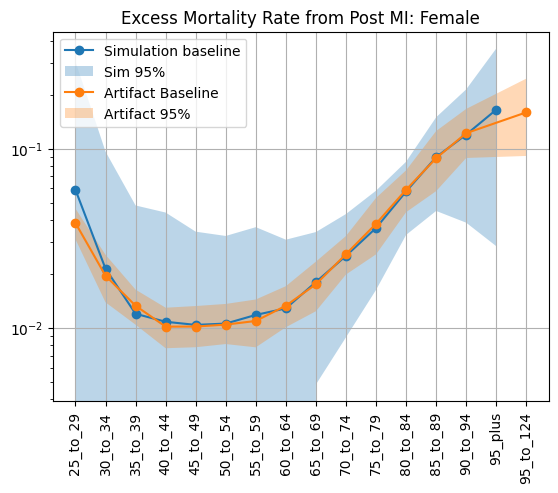

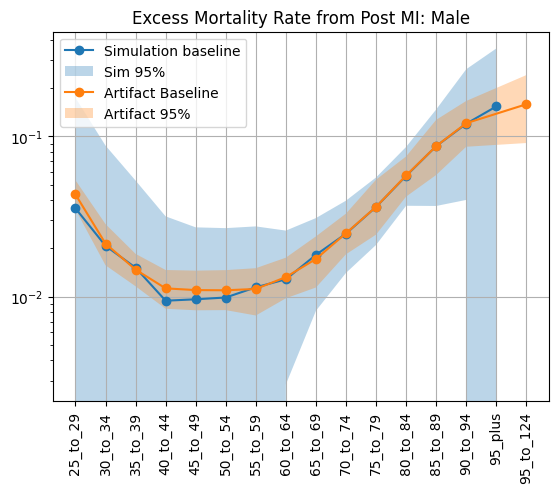

In [96]:
for sex in post_mi_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = post_mi_rate_emr_allyear.loc[(post_mi_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_postMI.loc[(art_emr_postMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 